## Study of the tradeoff between the number of bootstrap iterations, the sample size, and the estimate confidence.

In [8]:
%load_ext autoreload
%autoreload 2

import time  # noqa
import sys  # noqa
import itertools  # noqa
import matplotlib.pyplot as plt  # noqa: E402
import numpy as np  # noqa

import pandas as pd  # noqa

sys.path.append("..")

from backend.llm.ranking import ChoixRankerConfIntervals  # noqa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load battles from LS

In [2]:
# Load the LS battles.

local_file_name = "../tmp/clean_battle_20240814_public.json"
with open(local_file_name) as file:
    battles = pd.read_json(file).sort_values(ascending=True, by=["tstamp"])
battles = battles[(battles["anony"]) & (battles["dedup_tag"].apply(lambda x: x.get("sampled", False)))]
print(f"Loaded {len(battles)} raw battles")

Loaded 1670250 raw battles


#### Collect per-model confidence intervals and other statistics

In [3]:
def rank(num_bootstrap_iterations: int, num_battles: int, random_state: int):
    ranker = ChoixRankerConfIntervals(
        num_bootstrap_iterations=num_bootstrap_iterations,
        choix_ranker_algorithm="lsr_pairwise",
    )

    battles_sample = battles.sample(n=num_battles, random_state=random_state)
    for _, row in battles_sample.iterrows():
        model_a = row.model_a.lower()
        model_b = row.model_b.lower()

        if row.winner == "model_a":
            ranker.update(model_a, model_b, 1.0)
        elif "tie" in row.winner:
            ranker.update(model_a, model_b, 0.5)
        elif row.winner == "model_b":
            ranker.update(model_b, model_a, 1.0)
        else:
            raise ValueError(f"Unknown winner: {row.winner}")
    ratings = ranker.get_ratings_conf_intervals()
    battles_per_model = {model: ranker.get_num_samples(model) for model in ratings.keys()}
    res = []
    for model, (score_mean, (lower_bound, upper_bound)) in ratings.items():
        interval_width = upper_bound - lower_bound
        res.append(
            {
                "model": model,
                "confidence_interval_width": interval_width,
                "score_lower_bound": lower_bound,
                "score_upper_bound": upper_bound,
                "score_mean": score_mean,
                "num_battles": battles_per_model[model],
            }
        )
    return pd.DataFrame(res)

#### Run the study over exponentially increasing configurations

In [5]:
dfs = []
seed_options = (1, 2, 3)
bootstrap_iteration_options = list(reversed([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]))
total_battles_options = list(reversed([1000, 10000, 100000, 200000, 400000, 800000, 1600000]))
expected_total = len(seed_options) * len(bootstrap_iteration_options) * len(total_battles_options)


def run_study(num_bootstrap_iterations, total_battles, seed):
    df_new = rank(num_bootstrap_iterations, total_battles, seed)
    df_new["total_battles"] = total_battles
    df_new["num_bootstrap_iterations"] = num_bootstrap_iterations
    df_new["seed"] = seed
    return df_new


i = 0
for num_bootstrap_iterations, total_battles, seed in itertools.product(
    bootstrap_iteration_options, total_battles_options, seed_options
):
    i += 1
    start_time = time.time()
    print(f"{i}/{expected_total} {num_bootstrap_iterations=} {total_battles=} {seed=}", end="\t")
    dfs.append(run_study(num_bootstrap_iterations, total_battles, seed))
    print(f"done in {time.time() - start_time:.1f}s")

1/210 num_bootstrap_iterations=1024 total_battles=1600000 seed=1	done in 97.8s
2/210 num_bootstrap_iterations=1024 total_battles=1600000 seed=2	done in 95.8s
3/210 num_bootstrap_iterations=1024 total_battles=1600000 seed=3	done in 96.7s
4/210 num_bootstrap_iterations=1024 total_battles=800000 seed=1	done in 49.0s
5/210 num_bootstrap_iterations=1024 total_battles=800000 seed=2	done in 50.0s
6/210 num_bootstrap_iterations=1024 total_battles=800000 seed=3	done in 48.9s
7/210 num_bootstrap_iterations=1024 total_battles=400000 seed=1	done in 25.1s
8/210 num_bootstrap_iterations=1024 total_battles=400000 seed=2	done in 25.8s
9/210 num_bootstrap_iterations=1024 total_battles=400000 seed=3	done in 24.9s
10/210 num_bootstrap_iterations=1024 total_battles=200000 seed=1	done in 13.6s
11/210 num_bootstrap_iterations=1024 total_battles=200000 seed=2	done in 13.7s
12/210 num_bootstrap_iterations=1024 total_battles=200000 seed=3	done in 13.6s
13/210 num_bootstrap_iterations=1024 total_battles=100000 

In [6]:
full_df = pd.concat(dfs)
full_df.to_csv("data/bootstrap_study.csv", index=False)
full_df.head()

,model,confidence_interval_width,score_lower_bound,score_upper_bound,score_mean,num_battles,total_battles,num_bootstrap_iterations,seed
0,claude-3-haiku-20240307,11.734090,1221.125686,1232.859776,1227.236733,105273,1600000,1024,1
1,mixtral-8x22b-instruct-v0.1,17.414700,1103.492210,1120.906909,1112.296655,48118,1600000,1024,1
2,llama-3-70b-instruct,10.695967,1327.221046,1337.917012,1332.416387,154997,1600000,1024,1
3,command-r-plus,13.789624,1263.628367,1277.417991,1270.652259,77560,1600000,1024,1
4,mixtral-8x7b-instruct-v0.1,14.036481,991.928837,1005.965319,998.768099,72953,1600000,1024,1


#### Compare the confidence interval width for different configurations, as a function of the number of bootstrap iterations

/var/folders/44/drs75klx55zg65dwd906jzq00000gn/T/ipykernel_81630/1205770483.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("Set1")


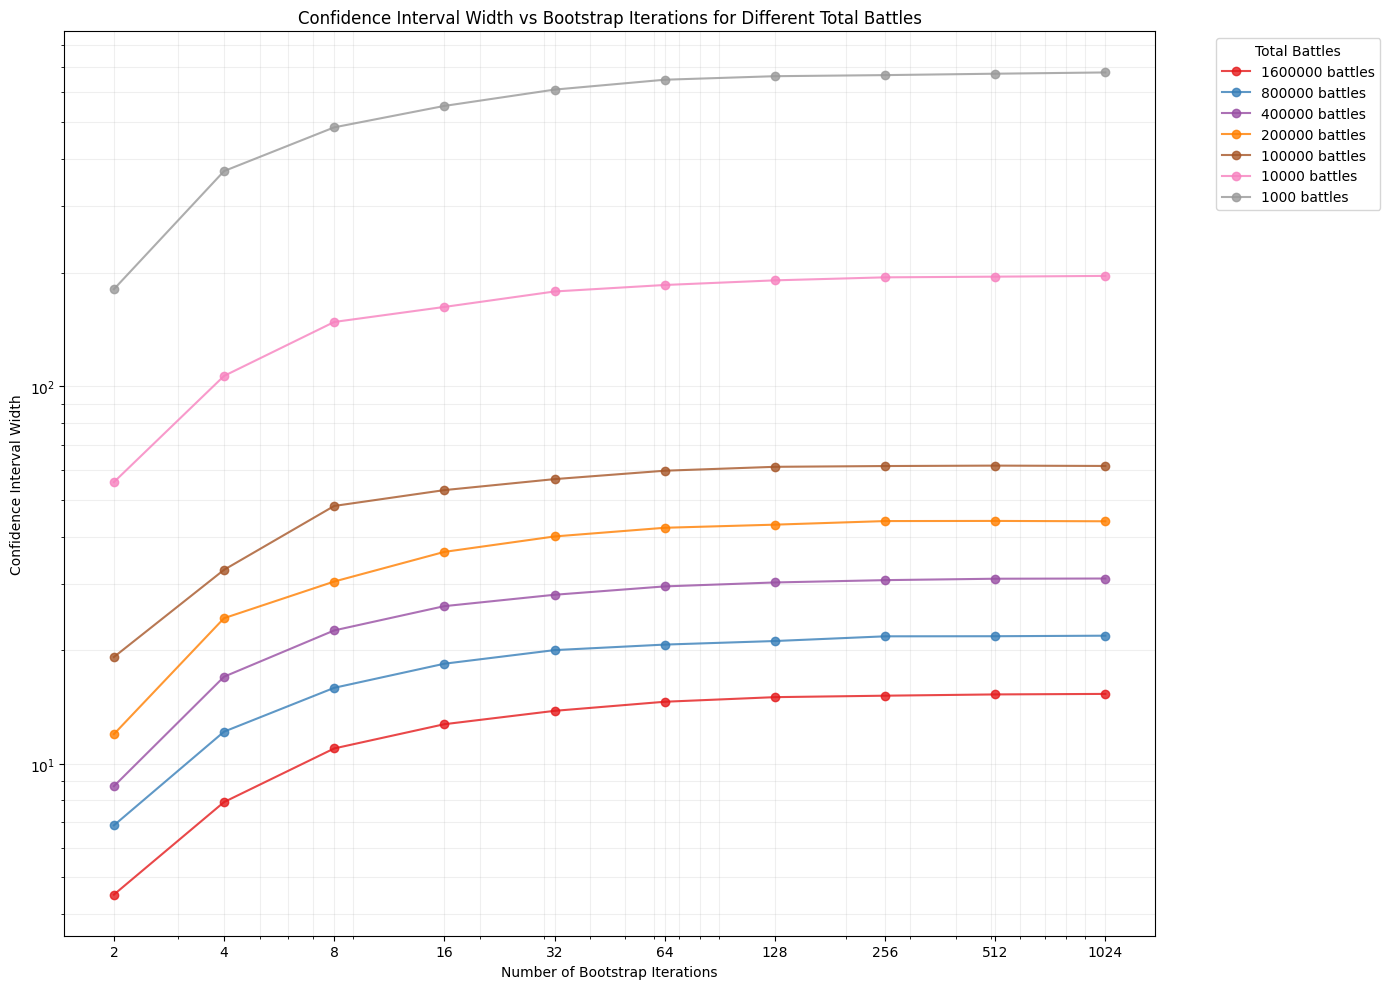

In [9]:
df = full_df
top_models = df.groupby("model")["num_battles"].max().nlargest(30).index

df_top = df[df["model"].isin(top_models)]

plt.figure(figsize=(14, 10))

unique_total_battles = df_top["total_battles"].unique()

color_map = plt.cm.get_cmap("Set1")
colors = [color_map(i) for i in np.linspace(0, 1, len(unique_total_battles))]

for total_battles, color in zip(unique_total_battles, colors, strict=True):
    data = df_top[df_top["total_battles"] == total_battles]
    plt.plot(
        data.groupby("num_bootstrap_iterations")["confidence_interval_width"].mean().index,
        data.groupby("num_bootstrap_iterations")["confidence_interval_width"].mean().values,
        "-o",
        color=color,
        alpha=0.8,
        label=f"{total_battles} battles",
    )

plt.xscale("log")
plt.yscale("log")
plt.xticks(df_top["num_bootstrap_iterations"].unique())
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().xaxis.set_minor_formatter(plt.NullFormatter())
plt.xlabel("Number of Bootstrap Iterations")
plt.ylabel("Confidence Interval Width")
plt.title("Confidence Interval Width vs Bootstrap Iterations for Different Total Battles")

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(title="Total Battles", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()